<h1 align="center">Optimizing Santander Cycles Pricing with Linear Regression and ARIMA</h1>
 <h3 align="center">December 2019</h3>

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
    * [1.1 Business Problem](#1.1-Business-Problem)
    * [1.2 Objective](#1.2-Objective)
* [2. Dataset](#2.-Dataset)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Exploring the Data](#4.-Exploring-the-Data)
    * [4.1 Variable Overview](#4.1-Variable-Overview)
    * [4.2 Data Visualisation](#4.2-Data-Visualisation)
        * [4.2.1 Distributions](#4.2.1-Distributions)
        * [4.2.2 Outliers](#4.2.2-Outliers)
* [5. Preparing the Data for Analysis](#5.-Preparing-the-Data-for-Analysis)
* [6. Linear Regression Model](#6.-Linear-Regression-Model)
* [7. Time Series - ARIMA](#7.-Time-Series---ARIMA)
* [8. Summary and Limitations](#8.-Summary-and-Limitations)
* [Appendix: Reflection on JIRA ](#Appendix:-Reflection-on-JIRA)
* [References](#References)

## 1. Introduction

### 1.1 Business Problem

Transport for London (TfL) is a local government body tasked with managing the transport system in Greater London. TfL is responsible for meeting the Mayor’s strategy on transport in Greater London. 

The strategy includes reaching the target that 80% of all journeys in London will be made on foot, by cycle or using public transport by 2041. 

TfL’s cycle hire scheme, Santander Cycles, is a service offering bike-rentals 24 hours a day, in London.

Hiring a Santander Cycle costs £2 and allows access to the bicycle for 24 hours. In 24 hours, customers can make as many journeys as they like. If the journey lasts less than 30 minutes, they are only charged with £2 for hire. If the journey lasts longer than 30 minutes, customers pay an additional £2 for every 30 minutes.

With this information in mind, we thought about how we, as data analysts, can help TfL and the Mayor of London achieve the goal of having 80% of all journeys in London made on foot, by cycle or public transport and came up with a problem we want to tackle with our analysis:


### How can TfL’s pricing strategy for Santander Cycles be improved to increase bicycle rentals?

### 1.2 Objective

We set out to analyze what drives demand for bike-rentals in London. We examine a number of variables on time and weather conditions. With our results, we want to advise TfL to improve their pricing strategy in a way that takes demand into account and incentivizes Londoners to use bike-rentals.

## 2. Dataset
The dataset we used for our analysis is the 'London bike sharing dataset' found on Kaggle under the following link: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset 

In [240]:
#ADDITION
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [241]:
# Adding package to load data
# import faculty.datasets as datasets

# Loading key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

# pretty graphs 
from pylab import *

vcvtype = 'nonrobust'

In [242]:
# loading the dataset to the variable bike_data
bike_data = pd.read_csv("./london_merged.csv", encoding = "ISO-8859-1")

# creating a DataFrame from bike_data
bike_df = pd.DataFrame(bike_data)

In [243]:
# first glance at dataset
bike_df.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,1/4/15 0:00,182,3.0,2.0,93.0,6.0,3,0,1,3
1,1/4/15 1:00,138,3.0,2.5,93.0,5.0,1,0,1,3
2,1/4/15 2:00,134,2.5,2.5,96.5,0.0,1,0,1,3
3,1/4/15 3:00,72,2.0,2.0,100.0,0.0,1,0,1,3
4,1/4/15 4:00,47,2.0,0.0,93.0,6.5,1,0,1,3
5,1/4/15 5:00,46,2.0,2.0,93.0,4.0,1,0,1,3
6,1/4/15 6:00,51,1.0,-1.0,100.0,7.0,4,0,1,3
7,1/4/15 7:00,75,1.0,-1.0,100.0,7.0,4,0,1,3
8,1/4/15 8:00,131,1.5,-1.0,96.5,8.0,4,0,1,3
9,1/4/15 9:00,301,2.0,-0.5,100.0,9.0,3,0,1,3


In [244]:
# show list of variables, number of observations per variable and datatype of each variable 
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
timestamp       17414 non-null object
cnt             17414 non-null int64
t1              17414 non-null float64
t2              17414 non-null float64
hum             17414 non-null float64
wind_speed      17414 non-null float64
weather_code    17414 non-null int64
is_holiday      17414 non-null int64
is_weekend      17414 non-null int64
season          17414 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 1.3+ MB


In [245]:
# checking categories of weather_code
bike_df['weather_code'].unique()

array([ 3,  1,  4,  7,  2, 26, 10], dtype=int64)

<b><font color=blue size=6>Do the weather_code values need some kind of explanation?</font></b>

In [246]:
# checking categories of holiday
bike_df['is_holiday'].unique()

array([0, 1], dtype=int64)

In [247]:
# checking categories of weekend
bike_df['is_weekend'].unique()

array([1, 0], dtype=int64)

In [248]:
# checking categories of season
bike_df['season'].unique()

array([3, 0, 1, 2], dtype=int64)

### Variable Description: </br>

<li>"cnt" - number of bike-rentals</li>
<li>"t1" - temparature in C</li>
<li>"t2" - temperature in C "feels like"</li>
<li>"hum" - humidity in %</li>
<li>"wind_speed" - wind speed in km/h</li>
<li>"weather_code" - weather category</li>
<li>"is_holiday" - boolean - 1 holiday / 0 non holiday</li>
<li>"is_weekend" - boolean - 1 if the day is weekend</li>
<li>"season" - meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter</li>

## 3. Data Cleaning & Preparation

In [249]:
# checking if there are any missing values in the dataset as a whole
bike_df.isnull().values.any()

False

As we want to study time effects on bike-rentals, we decided to transform the <i>timestamp</i> variable. We believe we can gain more insights by splitting up the <i>timestamp</i> variable into <i>year</i>, <i>month</i>, <i>month_name</i>, <i>day</i>, <i>weekday</i> and <i>hour</i>.

In [250]:
# creating empty columns to split the variable 'timestamp'
bike_df['year'] = ''
bike_df['month'] = ''
bike_df['month_name'] = ''
bike_df['day'] = ''
bike_df['weekday'] = ''
bike_df['hour'] = ''
bike_df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,month_name,day,weekday,hour
0,1/4/15 0:00,182,3.0,2.0,93.0,6.0,3,0,1,3,,,,,,
1,1/4/15 1:00,138,3.0,2.5,93.0,5.0,1,0,1,3,,,,,,
2,1/4/15 2:00,134,2.5,2.5,96.5,0.0,1,0,1,3,,,,,,
3,1/4/15 3:00,72,2.0,2.0,100.0,0.0,1,0,1,3,,,,,,
4,1/4/15 4:00,47,2.0,0.0,93.0,6.5,1,0,1,3,,,,,,


In [251]:
# copying the timestamp data into date_time variable
date_time = bike_df['timestamp']
date_time.head()

0    1/4/15 0:00
1    1/4/15 1:00
2    1/4/15 2:00
3    1/4/15 3:00
4    1/4/15 4:00
Name: timestamp, dtype: object

In [252]:
# converting the date_time variable to a datetime index
date_time = pd.to_datetime(date_time)
date_time.head()

0   2015-01-04 00:00:00
1   2015-01-04 01:00:00
2   2015-01-04 02:00:00
3   2015-01-04 03:00:00
4   2015-01-04 04:00:00
Name: timestamp, dtype: datetime64[ns]

In [253]:
# replacing the old 'timestamp' date format with the new 'date_time' format
bike_df['timestamp'] = date_time

In [254]:
# checking if code works
bike_df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,month_name,day,weekday,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,,,,,,
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,,,,,,
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,,,,,,
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,,,,,,
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,,,,,,


In [255]:
# splitting up 'timestamp' data into before defined columns
bike_df['year'] = pd.DatetimeIndex(bike_df['timestamp']).year
# month as number
bike_df['month'] = pd.DatetimeIndex(bike_df['timestamp']).month
# month in written form
bike_df['month_name'] = pd.DatetimeIndex(bike_df['timestamp']).month_name()
# # day as number
bike_df['day'] = pd.DatetimeIndex(bike_df['timestamp']).dayofweek
# # day in written form
bike_df['weekday'] = pd.DatetimeIndex(bike_df['timestamp']).day_name()
bike_df['hour'] = pd.DatetimeIndex(bike_df['timestamp']).hour

In [256]:
# checking if code works
bike_df.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,month_name,day,weekday,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,2015,1,January,6,Sunday,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,2015,1,January,6,Sunday,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,2015,1,January,6,Sunday,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,2015,1,January,6,Sunday,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,2015,1,January,6,Sunday,4
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1,0,1,3,2015,1,January,6,Sunday,5
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4,0,1,3,2015,1,January,6,Sunday,6
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4,0,1,3,2015,1,January,6,Sunday,7
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4,0,1,3,2015,1,January,6,Sunday,8
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3,0,1,3,2015,1,January,6,Sunday,9


## 4. Exploring the Data

With our data prepared for exploration, we started by exploring all variables and their characteristics such as data type, number of missing values, distribution and outliers.

### 4.1 Variable Overview

In [257]:
# list of variables
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 16 columns):
timestamp       17414 non-null datetime64[ns]
cnt             17414 non-null int64
t1              17414 non-null float64
t2              17414 non-null float64
hum             17414 non-null float64
wind_speed      17414 non-null float64
weather_code    17414 non-null int64
is_holiday      17414 non-null int64
is_weekend      17414 non-null int64
season          17414 non-null int64
year            17414 non-null int64
month           17414 non-null int64
month_name      17414 non-null object
day             17414 non-null int64
weekday         17414 non-null object
hour            17414 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(9), object(2)
memory usage: 2.1+ MB


In [258]:
# checking the data type of each variable
bike_df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code             int64
is_holiday               int64
is_weekend               int64
season                   int64
year                     int64
month                    int64
month_name              object
day                      int64
weekday                 object
hour                     int64
dtype: object

In [259]:
# checking for missing values per variable
bike_df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
year            0
month           0
month_name      0
day             0
weekday         0
hour            0
dtype: int64

In [260]:
# summary statistics
bike_df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.00000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075,2015.507810,6.514643,2.99265,11.513265
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911,0.508157,3.452509,2.00406,6.915893
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,0.00000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000,2015.000000,4.000000,1.00000,6.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000,2016.000000,7.000000,3.00000,12.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000,2016.000000,10.000000,5.00000,18.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,2017.000000,12.000000,6.00000,23.000000


### Detecting Outliers

In [261]:
# calculating the absolute Z-score for year
z1 = np.abs(stats.zscore(bike_df["year"]))
print(z1)

[0.99934641 0.99934641 0.99934641 ... 2.93656185 2.93656185 2.93656185]


In [262]:
# finding and printing observations where the Z-score is above 3
print(np.where(z1 > 3))

(array([], dtype=int64),)


<b><font color=blue size=6>What period of time is covered by the data? Probably should have been mentioned earlier!</font></b>

In [263]:
#ADDITION
bike_df["year"].max()
bike_df["year"].min()

2017

2015

In [ ]:
# calculating the absolute Z-score for month
z2 = np.abs(stats.zscore(bike_df["month"]))
print(z2)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z2 > 3))

In [ ]:
# calculating the absolute Z-score for day
z3 = np.abs(stats.zscore(bike_df["day"]))
print(z3)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z3 > 3))

In [ ]:
# calculating the absolute Z-score for hour
z4 = np.abs(stats.zscore(bike_df["hour"]))
print(z4)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z4 > 3))

In [ ]:
# calculating the absolute Z-score for t1
z5 = np.abs(stats.zscore(bike_df["t1"]))
print(z5)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z5 > 3))

In [ ]:
# calculating the absolute Z-score for t2
z6 = np.abs(stats.zscore(bike_df["t2"]))
print(z6)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z6 > 3))

In [ ]:
# calculating the absolute Z-score for hum
z7 = np.abs(stats.zscore(bike_df["hum"]))
print(z7)

In [ ]:
# finding and printing observations where the Z-score is above 3
print(np.where(z7 > 3))

In [264]:
# calculating the absolute Z-score for wind_speed
z8 = np.abs(stats.zscore(bike_df["wind_speed"]))
print(z8)

[1.25571722 1.38239019 2.01575507 ... 1.02439634 0.89772337 0.77105039]


In [265]:
# finding and printing observations where the Z-score is above 3
print(np.where(z8 > 3))

(array([  138,   139,   140,   141,   142,   144,   145,   146,   151,
         152,   153,   154,   155,   157,   262,   263,   264,   265,
         266,   586,   587,  1354,  1377,  1378,  1379,  2027,  2028,
        2030,  2060,  2061,  2062,  2063,  2064,  2065,  2066,  2067,
        2068,  2069,  2070,  2071,  2072,  2073,  2074,  2075,  2908,
        2909,  2910,  2911,  2912,  2913,  2914,  2932,  2933,  3222,
        3569,  3582,  3583,  3584,  7528,  7530,  7531,  7535,  7538,
        7539,  7592,  7595,  7596,  7597,  7604,  7605,  7867,  7869,
        7870,  7871,  7872,  8016,  8019,  8020,  8021,  8413,  8415,
        8799,  8800,  8801,  9398,  9406,  9407,  9408,  9518,  9520,
        9522,  9524,  9558,  9559,  9560,  9561,  9562,  9563,  9564,
        9565,  9566,  9567,  9872, 10112, 10113, 10693, 10698, 10710,
       10711, 10713, 10714, 10715, 10716, 10717, 10718, 10720, 10721,
       10940, 15243], dtype=int64),)


<b><font color=blue size=6>How many observations? Having identified them what should be done with them?</font></b>

In [266]:
# ADDITION
ar8 = np.where(z8 > 3)
type(ar8)
len(ar8)
len(ar8[0])

tuple

1

119

### 4.2 Data Visualisation

### 4.2.1 Distributions

For a quick overview of the distributions and correlation between variables we visualized histograms for each variable and a heatmap for the whole DataFrame.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5E15760F0>,
      dtype=object)

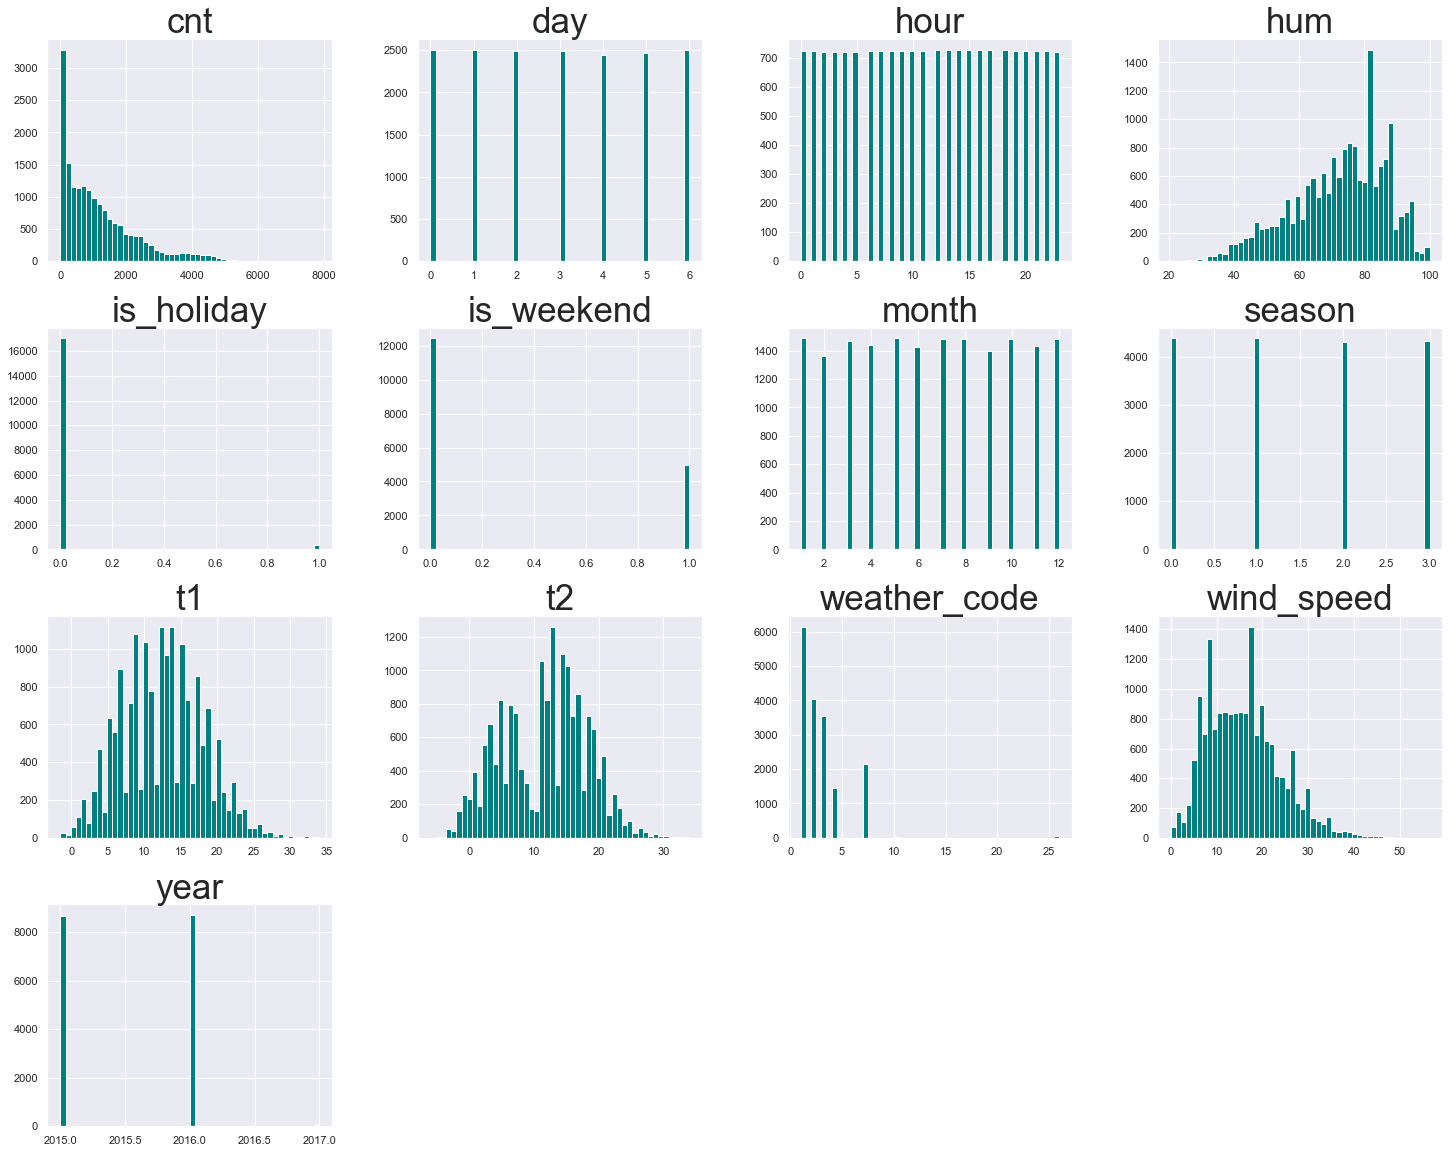

In [267]:
# initial histogram visualisations
%matplotlib inline

bike_df.hist(bins=50, figsize=(25,20), color = "teal");

plt.show()

<b><font color=blue size=6>What are the graphs telling us about the data?  Are some graphs worth investigating further?</font></b>

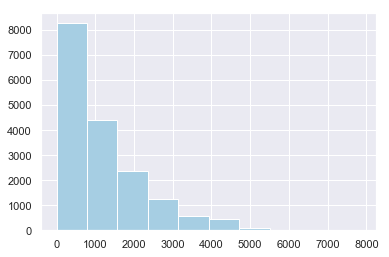

In [268]:
# ADDITION - Some graphs are more interesting than others
bike_df["cnt"].hist()


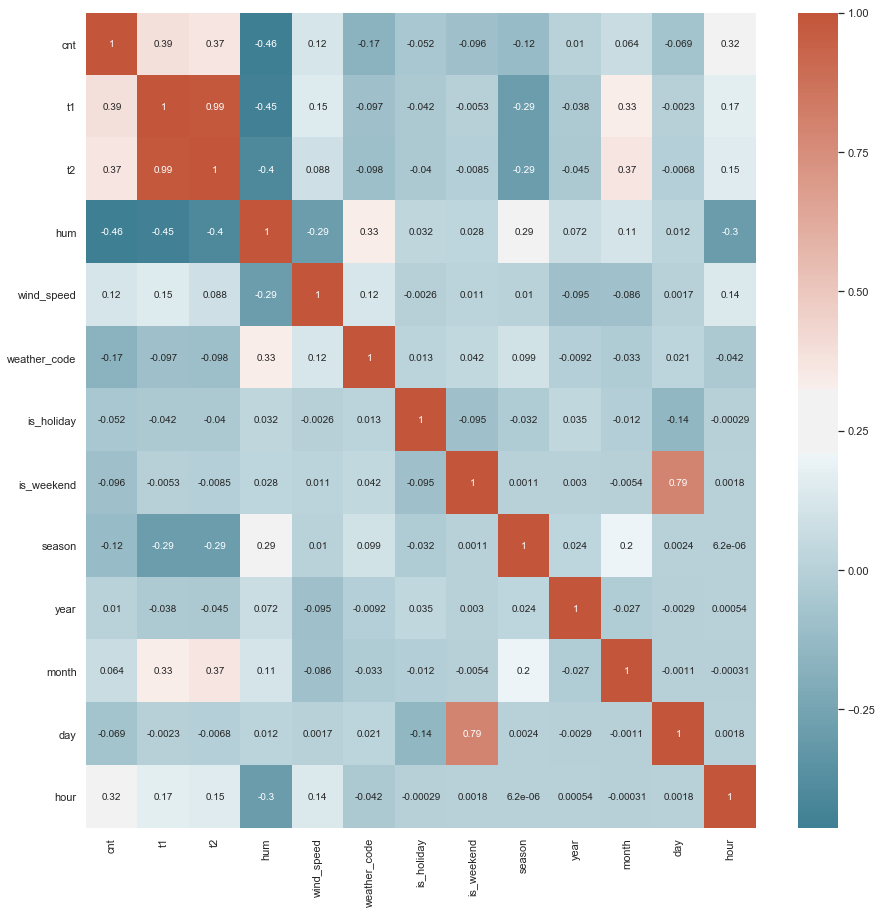

In [269]:
# initial correlation matrix
corrheat = bike_df.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corrheat, vmax=1, annot=True, cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True));

<b><font color=blue size=6>Where is the initial interpretation of the correlation heatmap?</font></b>


With this overview in mind, we explore the variables in greater detail.

### Overall demand

In a first step we explore the total number of bike-rentals across the time frame of two years.

In [270]:
#Adding columns for weeks and months per year
bike_df['date'] = pd.to_datetime(bike_df['timestamp']).dt.normalize()
bike_df['week-year'] = pd.to_datetime(bike_df['timestamp']).dt.strftime('%Y-%U')
bike_df['month-year'] = pd.to_datetime(bike_df['timestamp']).dt.strftime('%Y-%m')
bike_df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,month_name,day,weekday,hour,date,week-year,month-year
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,2015,1,January,6,Sunday,0,2015-01-04,2015-01,2015-01
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,2015,1,January,6,Sunday,1,2015-01-04,2015-01,2015-01
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,2015,1,January,6,Sunday,2,2015-01-04,2015-01,2015-01
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,2015,1,January,6,Sunday,3,2015-01-04,2015-01,2015-01
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,2015,1,January,6,Sunday,4,2015-01-04,2015-01,2015-01


<b><font color=blue size=6>What is reason for looking at weeks and months in each year?</font></b>

Text(0.5, 0, 'Week of Year')

Text(0, 0.5, 'Total number of bike rentals')

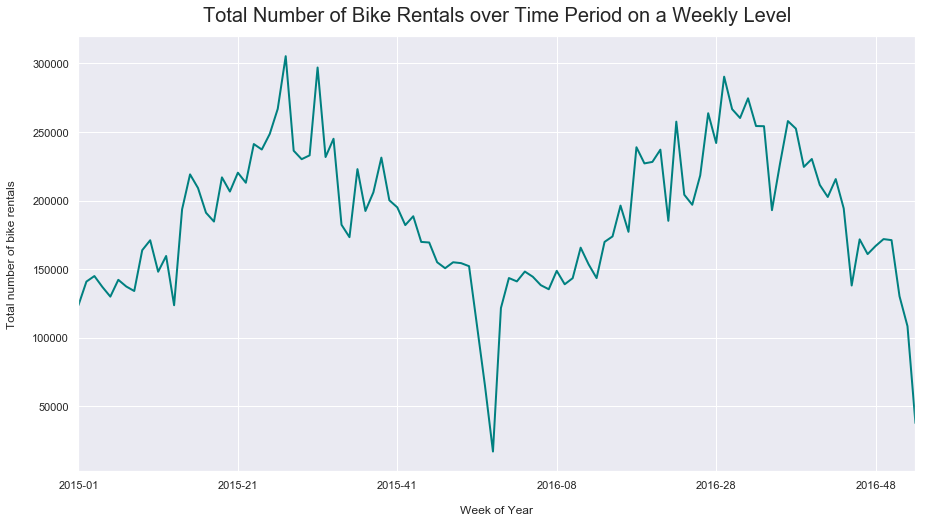

In [271]:
# Plot total number of bike rentals per week over time period
bike_df.groupby('week-year')['cnt'].sum().plot(kind='line', figsize=(15,8), color="teal",  linewidth=2)

#set title
plt.title('Total Number of Bike Rentals over Time Period on a Weekly Level', fontsize = 20).set_position([.5, 1.02])

#set x-axis label
plt.xlabel('Week of Year', fontsize = 12, labelpad=15)

#set y-axis label
plt.ylabel('Total number of bike rentals', fontsize = 12, labelpad=15)

plt.show()

Text(0.5, 0, 'Month of Year')

Text(0, 0.5, 'Total Number of Bike Rentals')

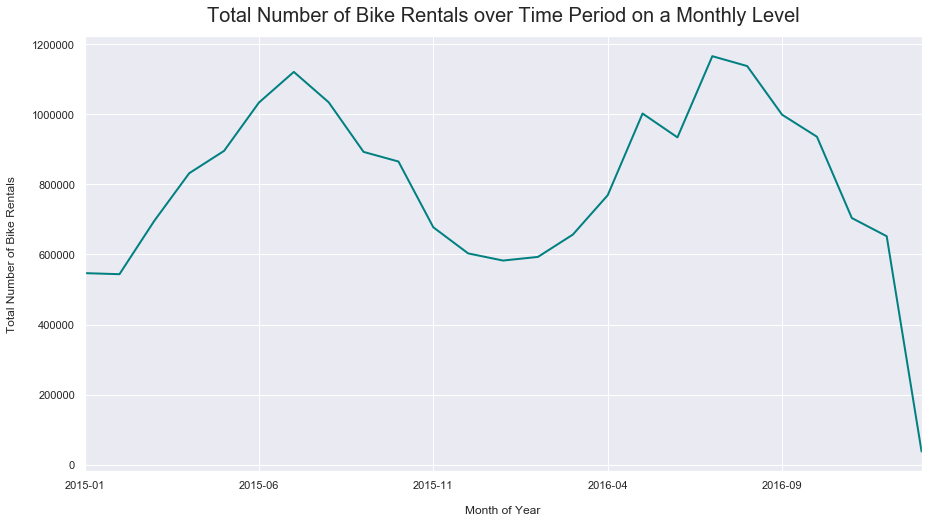

In [272]:
# Plot total number of bike rentals per month over time period

bike_df.groupby('month-year')['cnt'].sum().plot(kind='line', figsize=(15,8), color="teal",  linewidth=2)

#set title
plt.title('Total Number of Bike Rentals over Time Period on a Monthly Level', fontsize = 20).set_position([.5, 1.02])

#set x-axis label
plt.xlabel('Month of Year', fontsize = 12, labelpad=15)

#set y-axis label
plt.ylabel('Total Number of Bike Rentals', fontsize = 12, labelpad=15)

plt.show()

### Months


In [273]:
# Creating new dataset to group by month_name
df1 = bike_df[['cnt','month_name']].groupby(['month_name']).sum()
month_index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df1 = df1.reindex(month_index, axis=0)
df1 = df1.reset_index()
df1

,month_name,cnt
0,January,1166837
1,February,1136504
2,March,1352461
3,April,1600427
4,May,1897348
5,June,1967130
6,July,2286214
7,August,2171265
8,September,1891097
9,October,1800752


(-1, 12)

([<matplotlib.axis.XTick at 0x1d5d7fc2668>,
 <a list of 12 Text xticklabel objects>)

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Total Number of Bike Rentals')

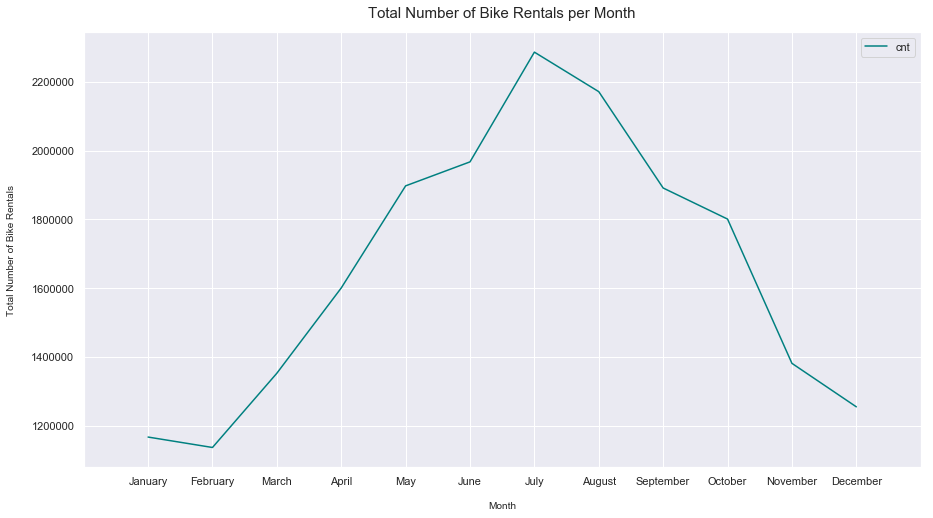

In [274]:
# Plot total number of bike rentals per month
df1.plot.line(x='month_name', y='cnt', rot =0, figsize=(15,8), color="teal") 

# setting x limits
plt.xlim(-1, 12);

# setting x ticks
labels = ("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
plt.xticks(np.linspace(0,12,12, endpoint=False), labels);

plt.title('Total Number of Bike Rentals per Month', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Month', fontsize = 10, labelpad=15)
plt.ylabel('Total Number of Bike Rentals', fontsize = 10, labelpad=15)
plt.show()

In [275]:
# Creating new dataset to group by month_name and calculating the average number of bike rentals
df2 = bike_df[['cnt','month_name']].groupby(['month_name']).mean()
month_index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df2 = df2.reindex(month_index, axis=0)
df2 = df2.reset_index()
df2

,month_name,cnt
0,January,784.691997
1,February,836.279617
2,March,921.294959
3,April,1112.953408
4,May,1275.099462
5,June,1383.354430
6,July,1543.696151
7,August,1463.116577
8,September,1356.597561
9,October,1217.546991


<b><font color=blue size=6>Why look at the average number of bike rentals? Assume this is per day!  </font></b>

(-1, 12)

([<matplotlib.axis.XTick at 0x1d5d86dd128>,
 <a list of 12 Text xticklabel objects>)

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Total Number of Bike Rentals')

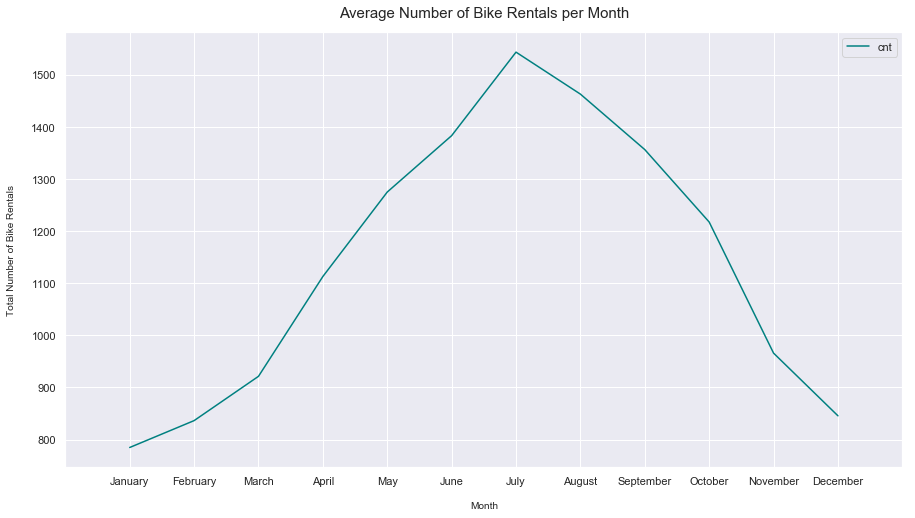

In [276]:
df2.plot.line(x='month_name', y='cnt', rot =0, figsize=(15,8), color = "teal") 

# setting x limits
plt.xlim(-1, 12);

# setting x ticks
labels = ("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
plt.xticks(np.linspace(0,12,12, endpoint=False), labels);

plt.title('Average Number of Bike Rentals per Month', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Month', fontsize = 10, labelpad=15)
plt.ylabel('Total Number of Bike Rentals', fontsize = 10, labelpad=15)
plt.show()

<b><font color=blue size=6>What draw a graph when the table holds the information?</font></b>

From these charts we can observe that the number of bike-rentals is the lowest during winter and peaks during the summer months. 

<b><font color=blue size=6>Is this a statement of the obvious? What about the changes in March and November?</font></b>

<Figure size 2160x504 with 0 Axes>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Number of Bike Rentals')

[Text(0, 0, 'January'),
 Text(0, 0, 'February'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'August'),
 Text(0, 0, 'September'),
 Text(0, 0, 'October'),
 Text(0, 0, 'November'),
 Text(0, 0, 'December')]

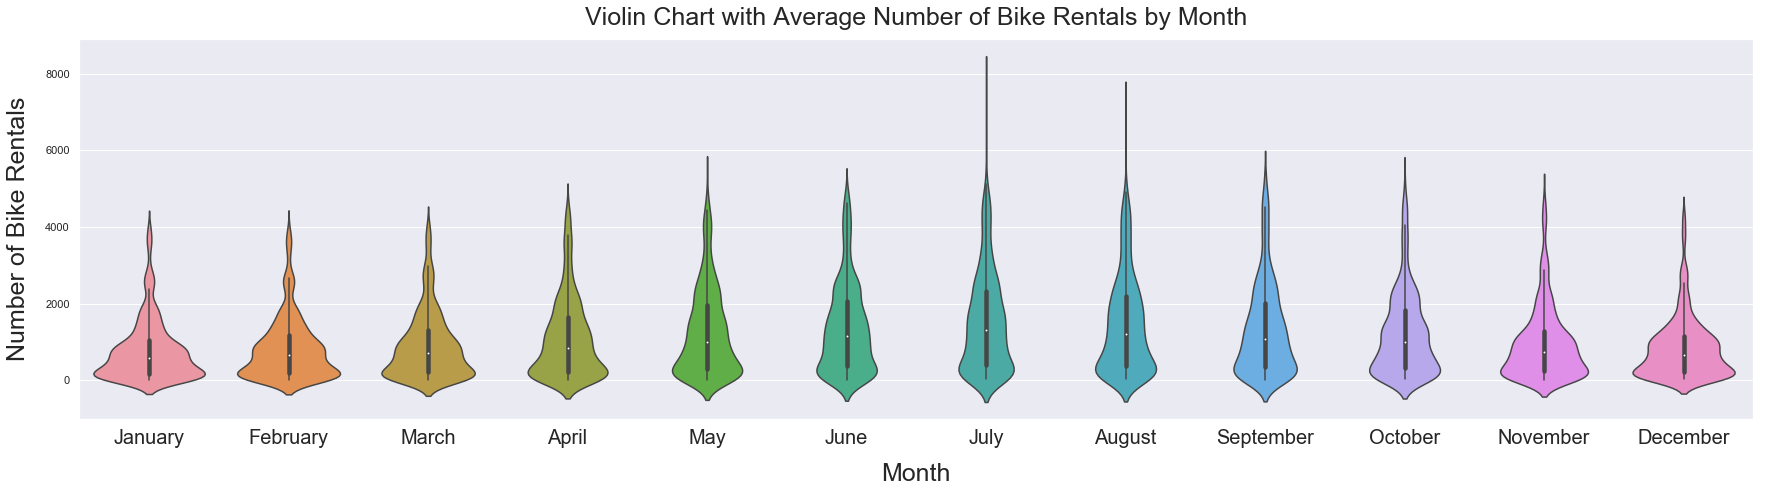

In [277]:
# violin plot
plt.figure(figsize = (30,7))
sns.set(rc={'font.size': 35, 'axes.titlesize': 35, 'axes.labelsize':35})
x=sns.violinplot(x='month_name', y='cnt', data=bike_df)
plt.title('Violin Chart with Average Number of Bike Rentals by Month', fontsize = 25).set_position([.5, 1.02])
plt.xlabel('Month', fontsize = 25, labelpad=15)
plt.ylabel('Number of Bike Rentals', fontsize = 25, labelpad=15)
x.set_xticklabels(x.get_xticklabels(), rotation=0, fontsize=20)

plt.show()

In the Violin Plot we can see the distribution and density of months. We can conclude that the number of bike-rentals is concentrated in a lower level in winter months, while the summer months are less concentrated.

<b><font color=blue size=6>What does this mean for the bike rental business?</font></b>

### Weekdays

In [278]:
# Creating new dataset to group by weekdays
df3 = bike_df[['cnt','weekday']].groupby(['weekday']).mean()
month_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df3 = df3.reindex(month_index, axis=0)
df3 = df3.reset_index()
df3

,weekday,cnt
0,Monday,1130.270734
1,Tuesday,1230.105389
2,Wednesday,1244.409000
3,Thursday,1258.810594
4,Friday,1182.772653
5,Saturday,995.553753
6,Sunday,959.567265


<b><font color=blue size=6>Can you improve the formatting of the Dataframe?</font></b>

In [279]:
# ADDITION
df3a = df3.rename(columns={"cnt": "mean"})
df3a = df3a.round(0)
df3a

,weekday,mean
0,Monday,1130.0
1,Tuesday,1230.0
2,Wednesday,1244.0
3,Thursday,1259.0
4,Friday,1183.0
5,Saturday,996.0
6,Sunday,960.0


(-1, 7)

([<matplotlib.axis.XTick at 0x1d5d8f3b080>,
 <a list of 7 Text xticklabel objects>)

Text(0.5, 0, 'Weekday')

Text(0, 0.5, 'Average Number of Bike Rentals')

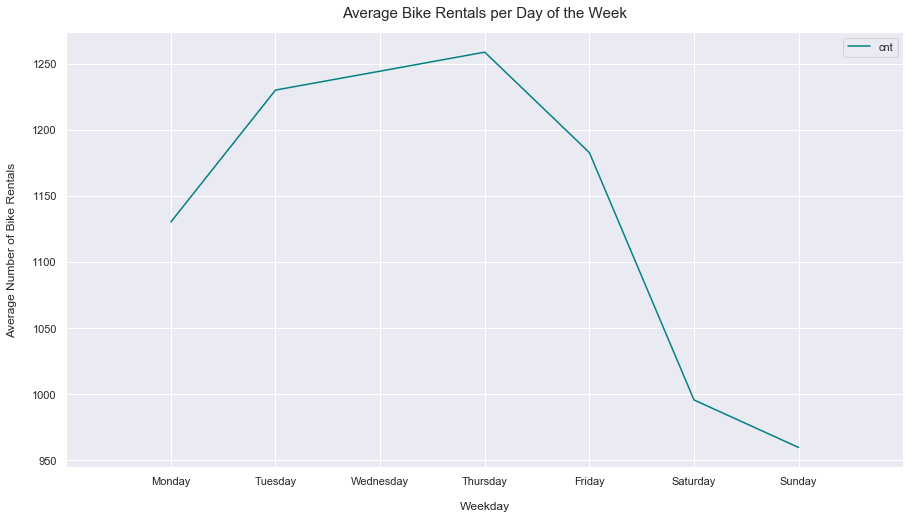

In [280]:
# Plot average number of bike rentals per weekday
df3.plot.line(x='weekday', y='cnt', rot =0, figsize=(15,8), color = "teal") 

# setting x limits
plt.xlim(-1, 7);

# setting x ticks
labels = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
plt.xticks(np.linspace(0,7,7,endpoint=False), labels);

plt.title('Average Bike Rentals per Day of the Week', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Weekday', fontsize = 12, labelpad=15)
plt.ylabel('Average Number of Bike Rentals', fontsize = 12, labelpad=15)
plt.show()

Our exploration so far showed that on average bike hires are the lowest during the weekend. One hypothesis for this is that customers use the bikes during the week to go to work. To prove this hypothesis, we look at the time of day the bikes are used the most:

<b><font color=blue size=6>What explains the plateau between Tuesday and Thursday?</font></b>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Number of Bike Rentals')

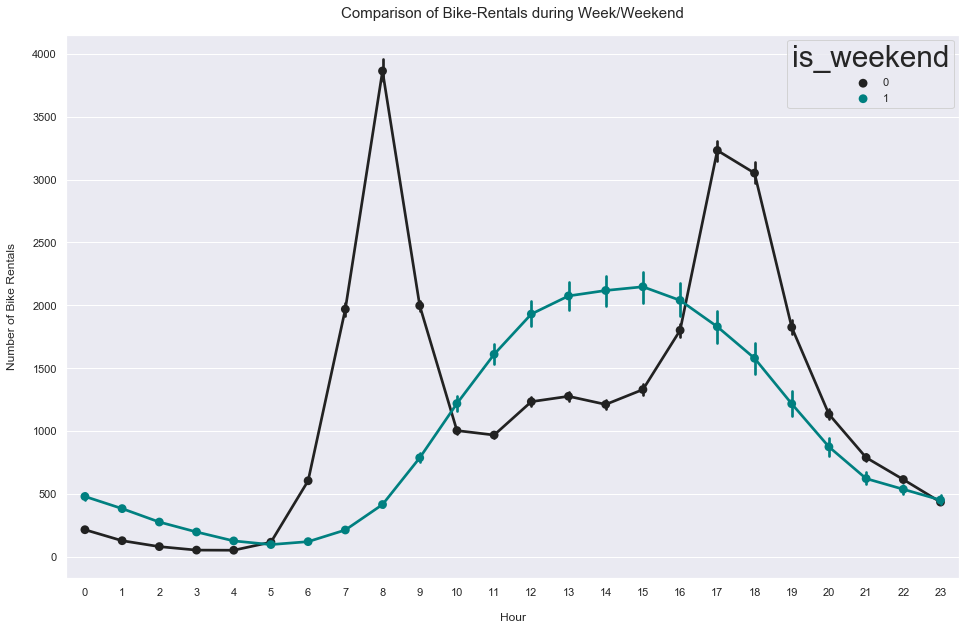

In [281]:
fig1,(ax1)= plt.subplots(nrows=1)
fig1.set_size_inches(16,10)

sns.set_palette("Paired")
sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=bike_df, ax=ax1, color = "teal")

plt.title('Comparison of Bike-Rentals during Week/Weekend', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Hour', fontsize = 12, labelpad=15)
plt.ylabel('Number of Bike Rentals', fontsize = 12, labelpad=15)

<b><font color=blue size=6>A graph without commentary is a lost opportunity!</font></b>

### Holiday

Text(0.5, 0, 'Holiday')

Text(0, 0.5, 'Number of Bike Rentals')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

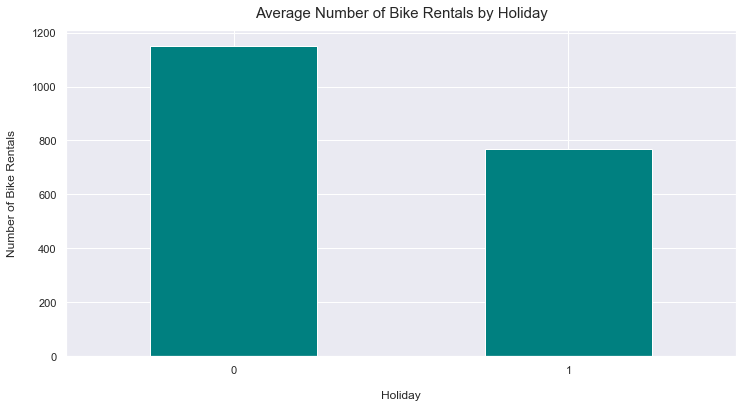

In [282]:
# Plot average number of biker rentals depending on holiday
bike_df.groupby('is_holiday')['cnt'].mean().plot.bar(figsize=(12,6), color = "teal")
plt.title('Average Number of Bike Rentals by Holiday', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Holiday', fontsize = 12, labelpad=15)
plt.ylabel('Number of Bike Rentals', fontsize = 12, labelpad=15)
plt.xticks(rotation=0)
plt.show()

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Number of Bike Rentals')

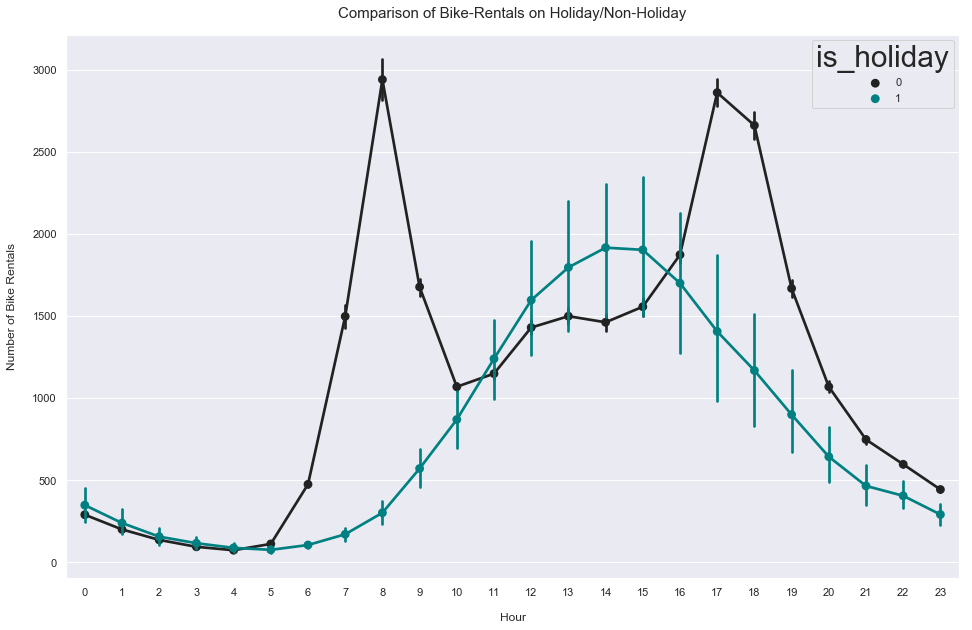

In [283]:
fig2,(ax2)= plt.subplots(nrows=1)
fig2.set_size_inches(16,10)

sns.set_palette("Paired")
sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=bike_df, ax=ax2, color = "teal")

plt.title('Comparison of Bike-Rentals on Holiday/Non-Holiday', fontsize = 15).set_position([.5, 1.02])
plt.xlabel('Hour', fontsize = 12, labelpad=15)
plt.ylabel('Number of Bike Rentals', fontsize = 12, labelpad=15)

<b><font color=blue size=6>The weekend and holiday graphs look similar. It they were plotted next to each would more insights be revealed ?</font></b>

[Text(0, 0.5, 'count'), Text(0.5, 0, 'hour')]

[Text(0, 0.5, 'count'), Text(0.5, 0, 'hour')]

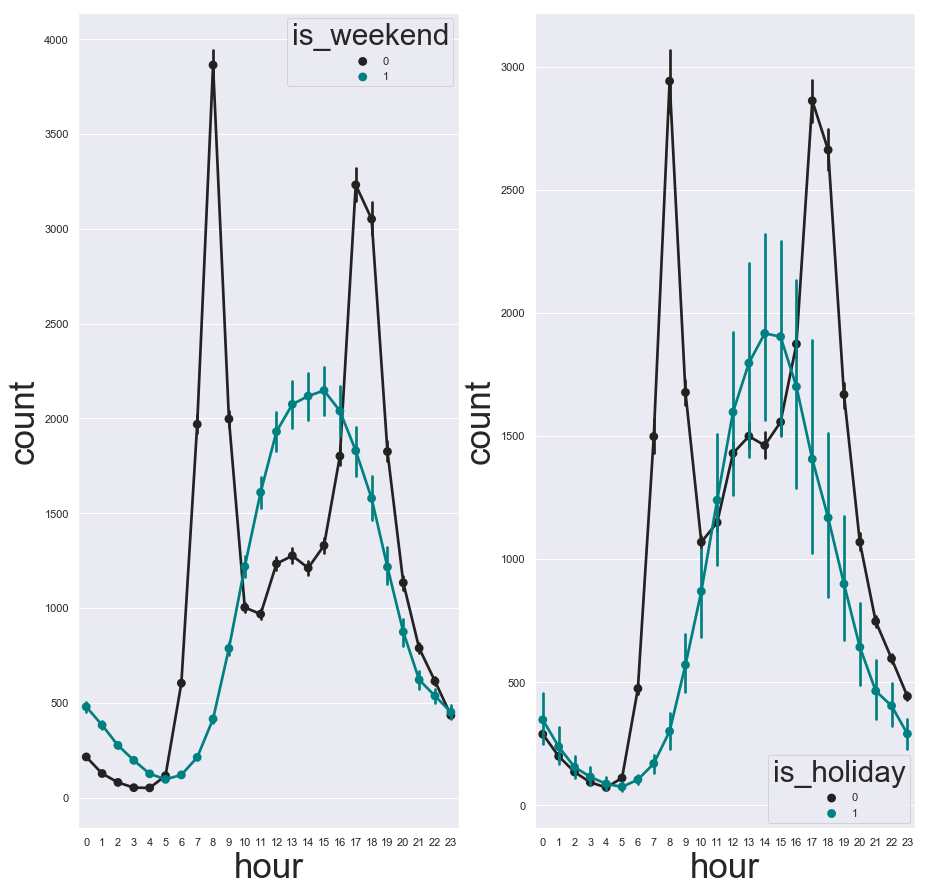

In [284]:
# ADDITION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

sns.set_palette("Paired")
ax1 = sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=bike_df, ax=ax1, color = "teal")
ax1.set(xlabel='hour', ylabel='count')

ax2 = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=bike_df, ax=ax2, color = "teal")
ax2.set(xlabel='hour', ylabel='count')

plt.show() # stops the display of multiple outputs

### Time of the day

In [285]:
# Creating new dataset to group by hour average
df4 = bike_df[['cnt','hour']].groupby(['hour']).mean()
df4 = df4.reindex(axis=0)
df4 = df4.reset_index()
df4.head()

,hour,cnt
0,0,290.609116
1,1,200.631215
2,2,136.303745
3,3,94.245492
4,4,73.313454


<b><font color=blue size=6>Can you improve the formatting of the Dataframe?</font></b>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Number of Bike Rentals')

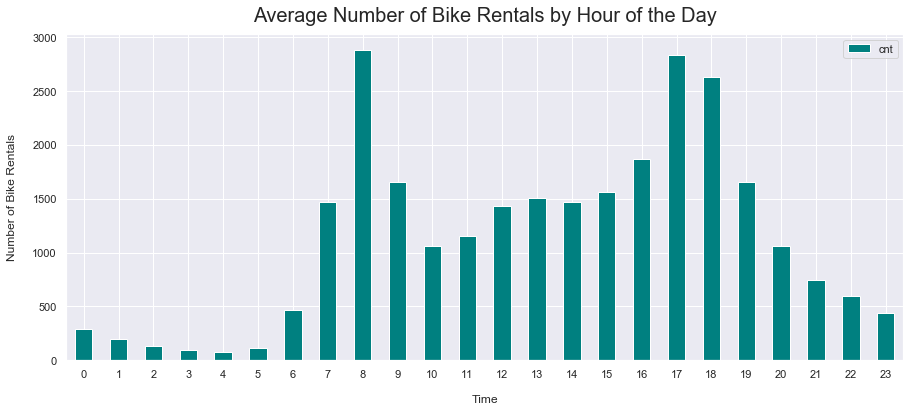

In [286]:
# Plotting average number of bike rentals during the day 
df4.plot.bar(x='hour', y='cnt', rot =0, figsize=(15,6), color = "teal") 
plt.title('Average Number of Bike Rentals by Hour of the Day', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Time', fontsize = 12, labelpad=15)
plt.ylabel('Number of Bike Rentals', fontsize = 12, labelpad=15)
plt.show()

The comparison graphs and the bar chart above show that there is a peak in demand of bike-rentals during the morning and the evening during the week. On the weekends and holidays, however, demand seems to peak in the early afternoon. Hence, we can conclude that people use bikes to commute to and from work or for leisure on the weekends.

### Temperature

Text(0.5, 0, 'Temerature in Celsius')

Text(0, 0.5, 'Total Number of Bike Rentals')

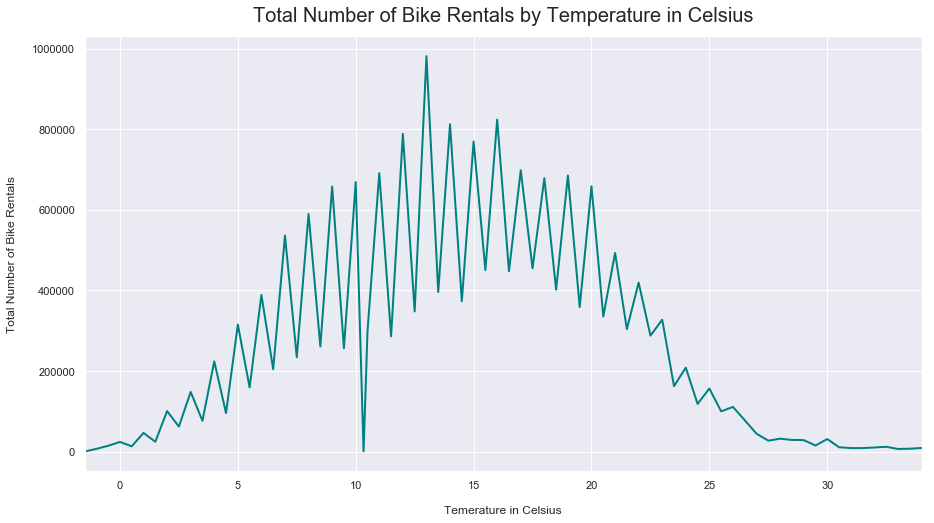

In [287]:
#Plot total numbers of bike rentals by temperature in Celsius
bike_df.groupby('t1')['cnt'].sum().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Total Number of Bike Rentals by Temperature in Celsius', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Temerature in Celsius', fontsize = 12, labelpad=15)
plt.ylabel('Total Number of Bike Rentals', fontsize = 12, labelpad=15)
plt.show()

<b><font color=blue size=6>Is this "actual" temperature or "as it feels" temperature?</font></b>

Looking at the total numbers of bike-rentals by temperature in celsius, we can see that most bikes were rented when the temperature was between 12 and 20 degrees celsius. This makes sense if we look at the overall temperature in London:

<b><font color=green size=6>Think about your markdown formatting!</font></b>

<b><font color=red size=6>INSIGHT X</font></b>
<br>
<br>
Looking at the total numbers of bike-rentals by temperature in celsius, we can see that most bikes were rented when the temperature was between 12 and 20 degrees celsius. This makes sense if we look at the overall temperature in London:

Text(0.5, 0, 'Time Period')

Text(0, 0.5, 'Temperature in Celsius')

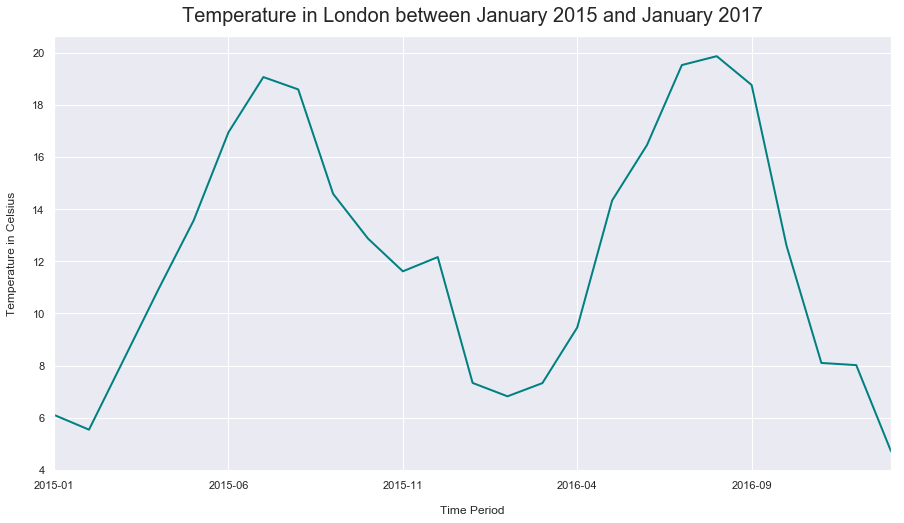

In [288]:
#Plot temperature per month in time frame
bike_df.groupby('month-year')['t1'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Temperature in London between January 2015 and January 2017', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Time Period', fontsize = 12, labelpad=15)
plt.ylabel('Temperature in Celsius', fontsize = 12, labelpad=15)
plt.show()

The above graph shows that the average temperature in London does not exceed 20 degrees celsius. 
<br><br>
To get a better understanding between the relationship of the number of bike-rentals and the temperature, we looked at the average number of bike-rentals by temperature.

Text(0.5, 0, 'Temperature in Celsius')

Text(0, 0.5, 'Average Number of Bike Rentals')

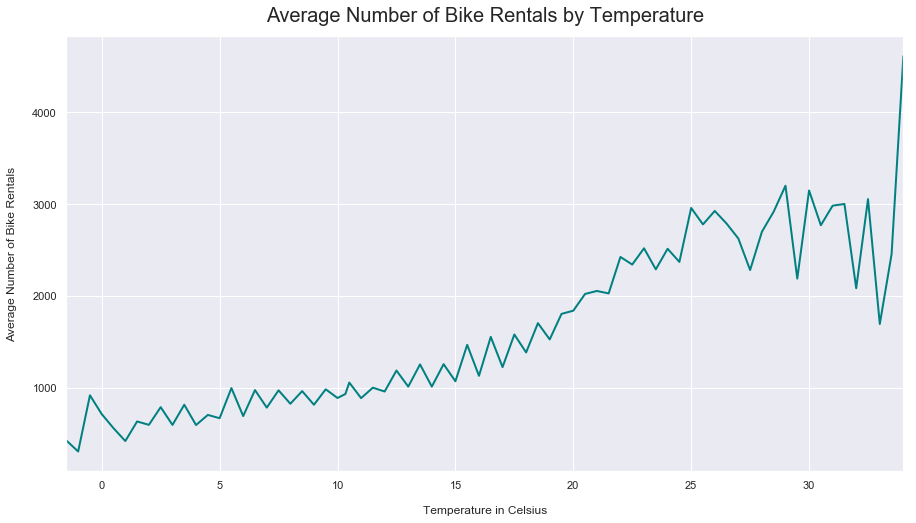

In [289]:
#Plot average numbers of bike rentals by temperature
bike_df.groupby('t1')['cnt'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Average Number of Bike Rentals by Temperature', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Temperature in Celsius', fontsize = 12, labelpad=15)
plt.ylabel('Average Number of Bike Rentals', fontsize = 12, labelpad=15)
plt.show()

The results show a clear relationship between the average number of bike-rentals and temperature. 

### Windspeed

Text(0.5, 0, 'Wind speed')

Text(0, 0.5, 'Average number of bike rentals')

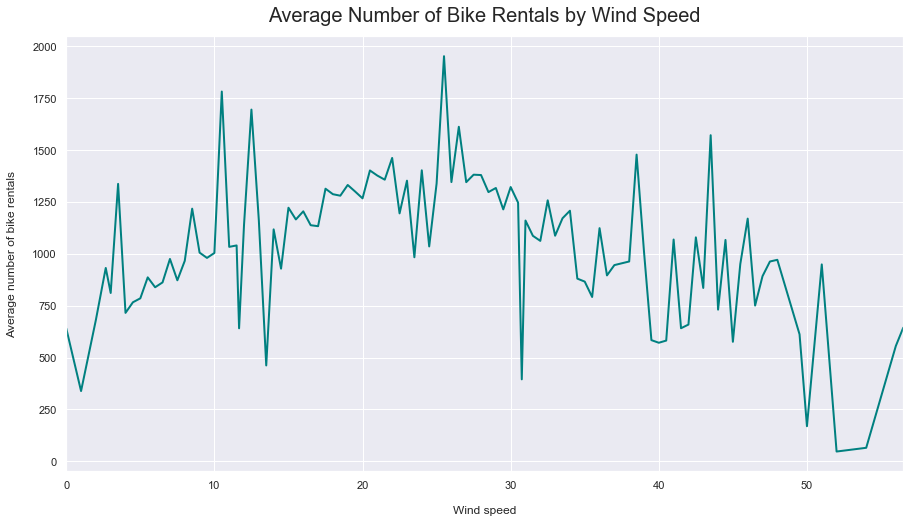

In [290]:
# Plot average number of bike rentals depending on the wind speed'
bike_df.groupby('wind_speed')['cnt'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Average Number of Bike Rentals by Wind Speed', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Wind speed', fontsize = 12, labelpad=15)
plt.ylabel('Average number of bike rentals', fontsize = 12, labelpad=15)
plt.show()

<b><font color=blue size=6>Does this graph say something more?</font></b>

Text(0.5, 0, 'Time Period')

Text(0, 0.5, 'Wind Speed')

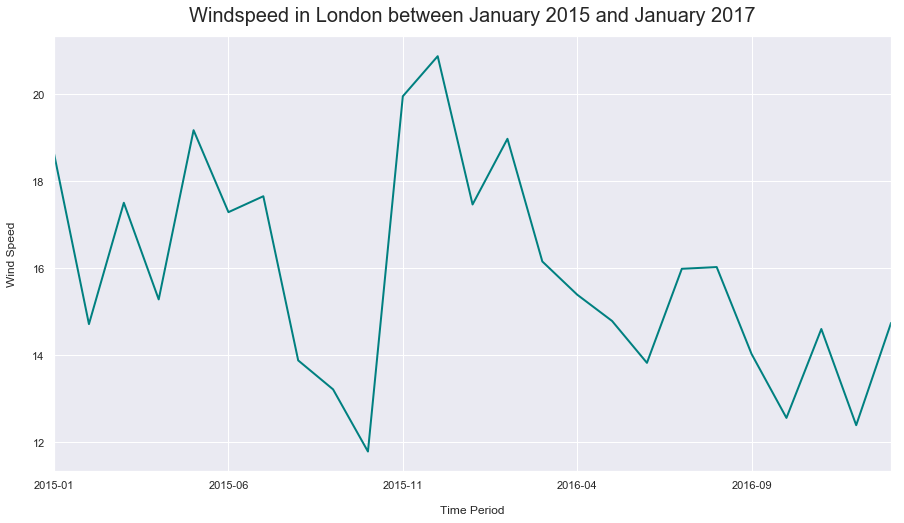

In [291]:
#Plot windspeed per month in time frame
bike_df.groupby('month-year')['wind_speed'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Windspeed in London between January 2015 and January 2017', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Time Period', fontsize = 12, labelpad=15)
plt.ylabel('Wind Speed', fontsize = 12, labelpad=15)
plt.show()

<b><font color=blue size=6>What's the purpose of this graph?</font></b>

When analyzing the demand by windspeed we do not observe any clear trend in correlation between the two variables.

### Humidity

Text(0.5, 0, 'Humidity')

Text(0, 0.5, 'Average number of bike rentals')

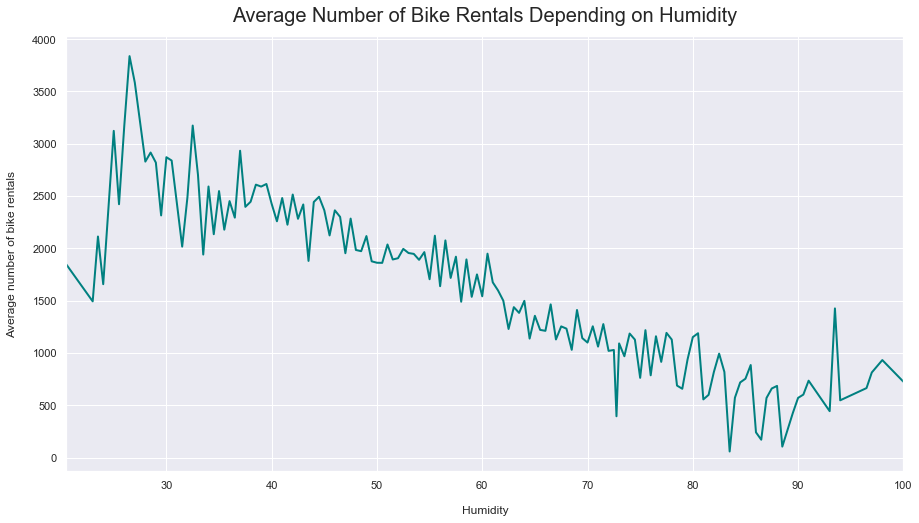

In [292]:
# Plot average number of bike rentals depending on thumidity'
bike_df.groupby('hum')['cnt'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Average Number of Bike Rentals Depending on Humidity', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Humidity', fontsize = 12, labelpad=15)
plt.ylabel('Average number of bike rentals', fontsize = 12, labelpad=15)
plt.show()

Text(0.5, 0, 'Time Period')

Text(0, 0.5, 'Wind Speed')

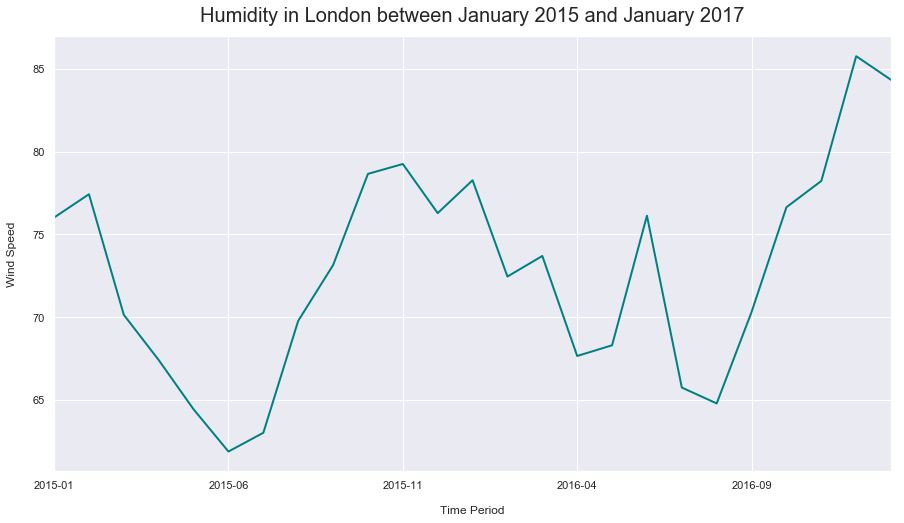

In [293]:
#Plot windspeed per month in time frame
bike_df.groupby('month-year')['hum'].mean().plot(kind='line', figsize=(15,8), color = "teal",  linewidth=2)
plt.title('Humidity in London between January 2015 and January 2017', fontsize = 20).set_position([.5, 1.02])
plt.xlabel('Time Period', fontsize = 12, labelpad=15)
plt.ylabel('Wind Speed', fontsize = 12, labelpad=15)
plt.show()

When analyzing the correlation between the demand of bike-rentals and humidity, we can observe a clear trend. Demand is highest when humidity is the lowest.

In [294]:
data_w = bike_df[["month-year", "t1", "wind_speed", "hum", "cnt"]]

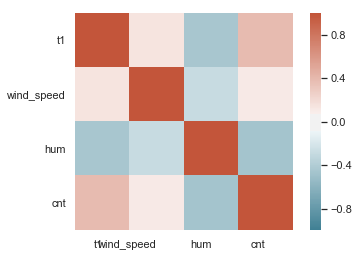

In [295]:
corr = data_w.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='right'
);

Looking at the correlation between the variables concerning weather, we observe a negative correlation between humidity (hum) and the temperature (t1). Hence, we cannot say with confidence whether the temperature or humidity drives demand. Moreover, we can see a positive correlation between temperature and number of bike-rentals (cnt), and a negative correlation between humidity and the number of bike-rentals. This supports our earlier findings.

We decided not to further explore the variable <i>weather_code</i>, <i>season</i> and <i>is_weekend</i> because their effects can be seen through other variables and they do not provide us with additional information.

### 4.2.2 Outliers

Text(0.5, 33.800000000000004, 'Year')

Text(24.675000000000004, 0.5, 'Count of Bike Rentals')

Text(0.5, 1.0, 'Bike Rentals by Year')

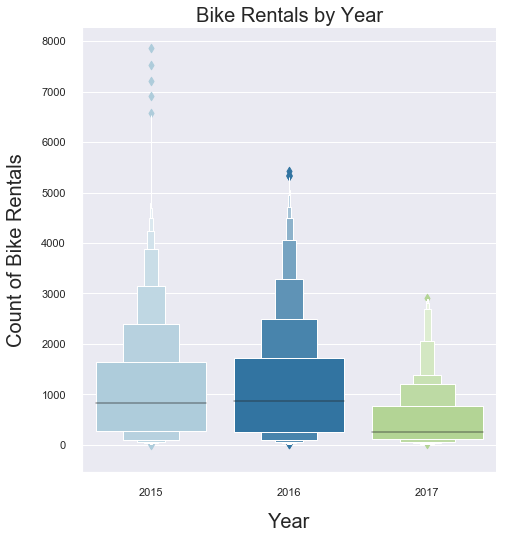

In [296]:
sns.catplot(x="year", y="cnt", kind="boxen",
            data=bike_df.sort_values("year"));

# changing label names
plt.xlabel("Year", fontsize=20, labelpad=15)
plt.ylabel("Count of Bike Rentals", fontsize=20, labelpad=15)

# adding graph title 
plt.title("Bike Rentals by Year", fontsize=20)

# changing the size of the graph
plt.gcf().set_size_inches(10, 10)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

<b><font color=blue size=6>Why could this graph be misleading?</font></b>

Text(0.5, 33.800000000000004, 'Month')

Text(24.675000000000004, 0.5, 'Count of Bike Rentals')

Text(0.5, 1.0, 'Bike Rentals by Month')

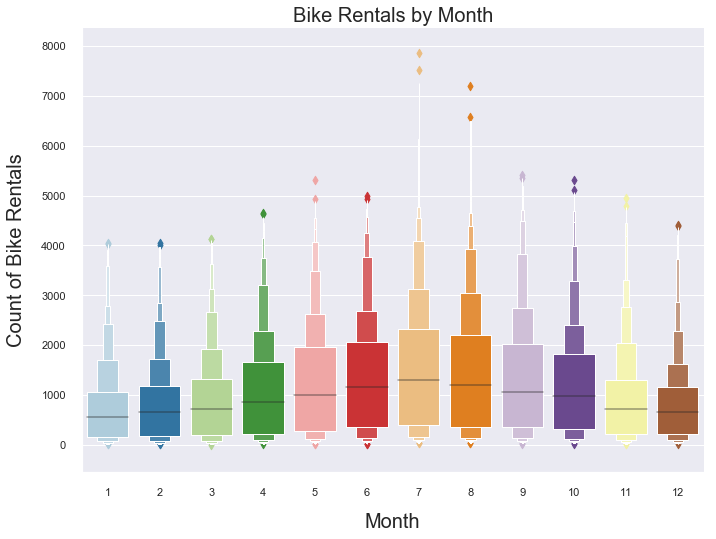

In [297]:
sns.catplot(x="month", y="cnt", kind="boxen",
            data=bike_df.sort_values("month"));

# changing label names
plt.xlabel("Month", fontsize=20, labelpad=15)
plt.ylabel("Count of Bike Rentals", fontsize=20, labelpad=15)

# adding graph title 
plt.title("Bike Rentals by Month", fontsize=20)

# changing the size of the graph
plt.gcf().set_size_inches(15, 10)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

Text(0.5, 33.800000000000004, 'Day')

Text(24.675000000000004, 0.5, 'Count of Bike Rentals')

Text(0.5, 1.0, 'Bike Rentals by Day')

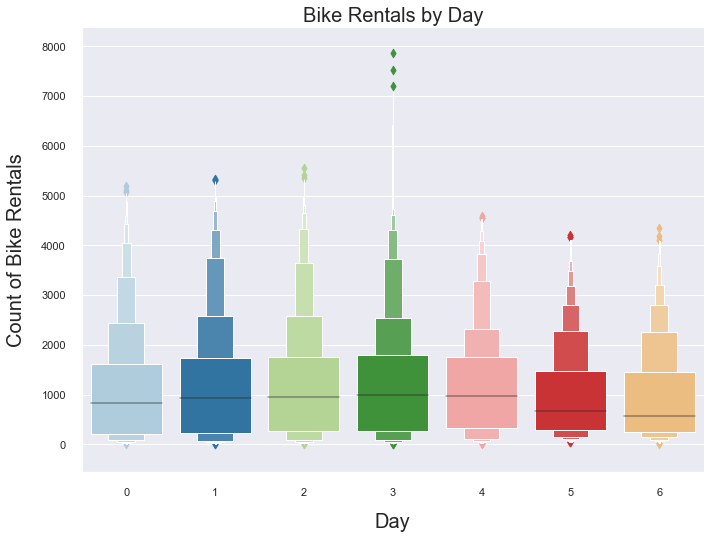

In [298]:
sns.catplot(x="day", y="cnt", kind="boxen",
            data=bike_df.sort_values("year"));

# changing label names
plt.xlabel("Day", fontsize=20, labelpad=15)
plt.ylabel("Count of Bike Rentals", fontsize=20, labelpad=15)

# adding graph title 
plt.title("Bike Rentals by Day", fontsize=20)

# changing the size of the graph
plt.gcf().set_size_inches(15, 10)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

<b><font color=blue size=6>Which day of week is 0? Showing day names instead of codes would be more informative!</font></b>

Text(0.5, 33.800000000000004, 'Hour')

Text(24.675000000000004, 0.5, 'Count of Bike Rentals')

Text(0.5, 1.0, 'Bike Rentals by Hour')

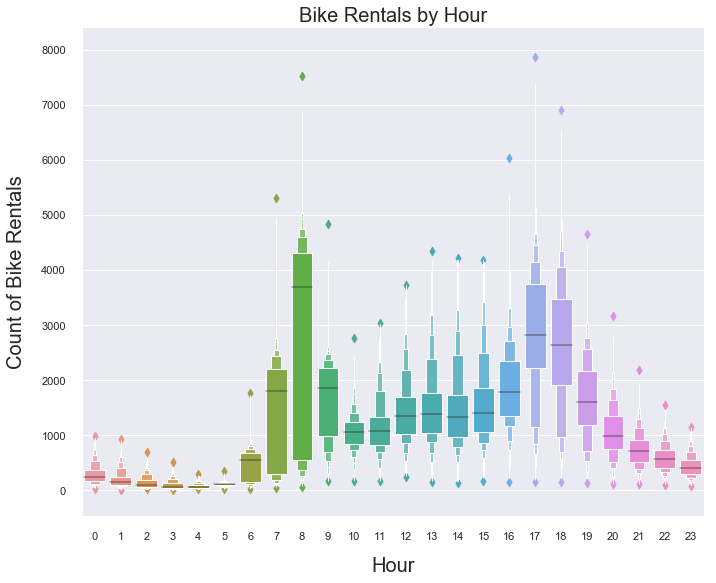

In [299]:
sns.catplot(x="hour", y="cnt", kind="boxen",
            data=bike_df.sort_values("hour"));

# changing label names
plt.xlabel("Hour", fontsize=20, labelpad=15)
plt.ylabel("Count of Bike Rentals", fontsize=20, labelpad=15)

# adding graph title 
plt.title("Bike Rentals by Hour", fontsize=20)

# changing the size of the graph
plt.gcf().set_size_inches(15, 11)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

(-5, 35)

([<matplotlib.axis.XTick at 0x1d5e4756668>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Temperature in Celsius')

Text(0, 0.5, 'Count of bike rentals')

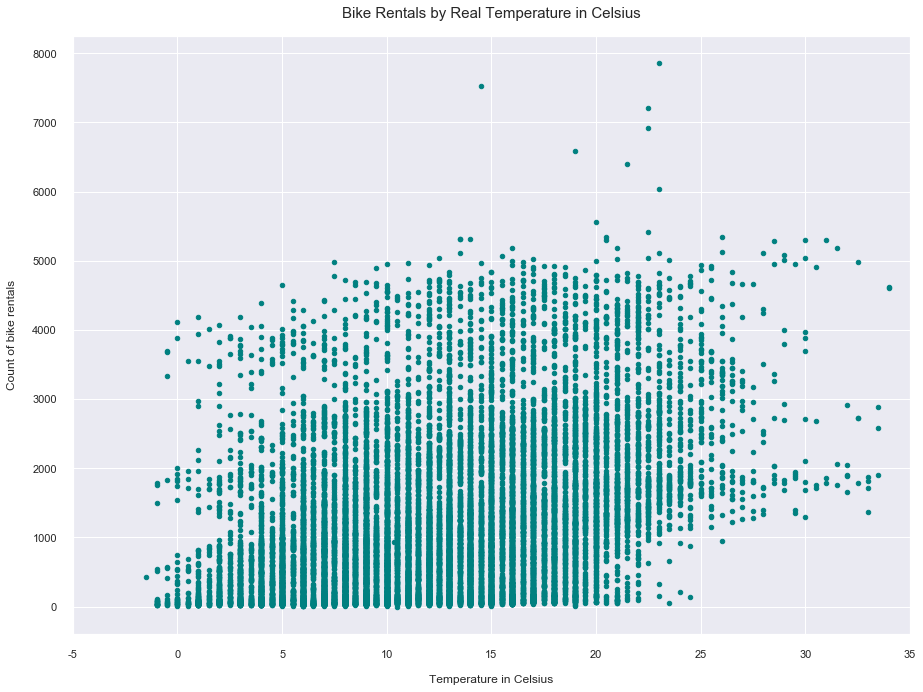

In [300]:
bike_df.plot(kind="scatter", x="t1", y="cnt", color="teal", figsize=(15,11));

# setting x limits
plt.xlim(-5,35);

# setting x ticks
labels = ("-5", "0", "5", "10", "15", "20", "25", "30", "35")
plt.xticks(np.linspace(-5,35,9, endpoint=True), labels);

# adding graph title 
plt.title('Bike Rentals by Real Temperature in Celsius', fontsize=15).set_position([.5, 1.02])

# changing label names
plt.xlabel('Temperature in Celsius', fontsize=12,labelpad=15)
plt.ylabel('Count of bike rentals', fontsize=12, labelpad=15)

# adding a legend
#plt.legend(loc='upper left', fontsize=12, frameon=True)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

In [ ]:
bike_df.plot(kind="scatter", x="t2", y="cnt", color="teal", figsize=(15,11));

# setting x limits
plt.xlim(-10,35);

# setting x ticks
labels = ("-10", "-5", "0", "5", "10", "15", "20", "25", "30", "35")
plt.xticks(np.linspace(-10,35,10, endpoint=True), labels);

# adding graph title 
plt.title('Bike Rentals by "Feels-Like" - Temperature in Celsius', fontsize=15).set_position([.5, 1.02])

# changing label names
plt.xlabel('"Feels-Like" - Temperature in Celsius', fontsize=12,labelpad=15)
plt.ylabel('Count of bike rentals', fontsize=12, labelpad=15)

# adding a legend
#plt.legend(loc='upper left', fontsize=12, frameon=True)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

In [ ]:
bike_df.plot(kind="scatter", x="hum", y="cnt", color="teal", figsize=(15,11));

# setting x limits
plt.xlim(10,110);

# setting x ticks
labels = ("20", "30", "40", "50", "60", "70", "80", "90", "100")
plt.xticks(np.linspace(20,100,9, endpoint=True), labels);

# adding graph title 
plt.title('Bike Rentals by Humidity in %', fontsize=15).set_position([.5, 1.02])

# changing label names
plt.xlabel('Humidity in %', fontsize=12,labelpad=15)
plt.ylabel('Count of bike rentals', fontsize=12, labelpad=15)

# adding a legend
#plt.legend(loc='upper left', fontsize=12, frameon=True)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

In [ ]:
bike_df.plot(kind="scatter", x="wind_speed", y="cnt", color="teal", figsize=(15,11));

# setting x limits
plt.xlim(-10,60);

# setting x ticks
labels = ("0", "10", "20", "30", "40", "50")
plt.xticks(np.linspace(0,60,7, endpoint=True), labels);

# adding graph title 
plt.title('Bike Rentals by Wind Speed in Km/h', fontsize=15).set_position([.5, 1.02])

# changing label names
plt.xlabel('Wind Speed in Km/h', fontsize=12,labelpad=15)
plt.ylabel('Count of bike rentals', fontsize=12, labelpad=15)

# adding a legend
#plt.legend(loc='upper left', fontsize=12, frameon=True)

# adding space between ticks and graph
plt.tick_params(axis='both', which='major', pad=10)

Our exploratory analysis showed that there are some outliers in our variables of interest. However, they are few and not extreme. It is important to keep them in mind for further analysis and interpretation but we can continue with our analysis without further data cleaning.

<b><font color=blue size=6>Is this a justifiable statement?</font></b>

## 5. Preparing the Data for Analysis

In order to run a linear regression model, we have to convert all categorical variables into dummy variables. The categorical variables are weather_code, is_holiday, is_weekend, and season. We add these four categorical variables into the linear regression model by dropping one of the categories to avoid perfect collinearity. 

In [301]:
# convert categorical variables into dummy variables
dummy1 = pd.get_dummies(bike_df['weather_code'],drop_first=True,prefix='weather_code')
dummy2 = pd.get_dummies(bike_df['is_holiday'],drop_first=True,prefix='holiday')
dummy3 = pd.get_dummies(bike_df['is_weekend'],drop_first=True,prefix='weekend')
dummy4 = pd.get_dummies(bike_df['season'],drop_first=True,prefix='season')

merged = pd.concat([bike_df,dummy1,dummy2,dummy3,dummy4],axis=1) #combine dummy variables with original dataset

final_bike=merged.drop(['is_holiday','is_weekend','weather_code','season'],axis='columns') #drop unnessary columns
final_bike.head()  #final dataset for the linear regression

,timestamp,cnt,t1,t2,hum,wind_speed,year,month,month_name,day,...,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26,holiday_1,weekend_1,season_1,season_2,season_3
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,2015,1,January,6,...,1,0,0,0,0,0,1,0,0,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,2015,1,January,6,...,0,0,0,0,0,0,1,0,0,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,2015,1,January,6,...,0,0,0,0,0,0,1,0,0,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,2015,1,January,6,...,0,0,0,0,0,0,1,0,0,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,2015,1,January,6,...,0,0,0,0,0,0,1,0,0,1


<b><font color=blue size=6>Given previous statement about weather code, why is it included in the final data?</font></b>

In [302]:
variables = ['t1', 't2', 'hum', 'wind_speed','weather_code_10', 'weather_code_2', 'weather_code_26',
       'weather_code_3', 'weather_code_4', 'weather_code_7', 'holiday_1',
       'weekend_1', 'season_1', 'season_2', 'season_3'] # Extract columns from original dataset
features = final_bike[variables]
X = features.values # Take corresponding values from variables as X
y = final_bike.iloc[:, 1].values # Define the value from the first column of final dataset as y 

In [303]:
print(X.shape)
print(y.shape) #Make sure X and y have the same number of columns

(17414, 15)
(17414,)


In [304]:
# split data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Splitting the data into training and testing set in order to avoid the overfitting problem. We set 80% of the dataset as training set and the remaining 20% of the dataset as testing set.

## 6. Linear Regression Model

We choose the linear regression model as the first choice because the dependent variable in our dataset, count of bike shares, is a continuous variable. In this case, using the linear regression model seems to fit best with our data. We use the training set to train our model first and then apply it to the testing set.

In [305]:
from sklearn.linear_model import LinearRegression # Import linear regression function
model = LinearRegression()  
model.fit(X_train, y_train) #Plug the training set

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [306]:
y_pred = model.predict(X_test)

In [307]:
#Prediction result
print(model.score(X_test, y_test))

0.28796597262251433


After using the training set to predict the testing set, the accuracy score was around 0.2880. This means our model is only 28.80% accurate for predicting new data.

In [308]:
#R-squared; adjusted R-squared
model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

(0.29040278778862816, 0.28979099573303724)

We also checked the R-squared and adjusted R-squared score. In our linear regression model, 29% of the variance in the dependent variable can be explained by the independent variables.

In [309]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head(15) #Show a table for the difference between the actual and predicted results

,Actual,Predicted
0,705,814.479449
1,958,1656.751437
2,497,544.477738
3,1392,2420.396704
4,3073,1891.614426
5,2190,1805.924248
6,138,1418.280283
7,1350,499.134291
8,1845,1288.946211
9,1705,1021.789928


The predicted results and resulting accuracy of our model were not optimistic. Our linear regression model does not have adequate explaining power and is not feasible to predict the number of bike-rental demand. Based on the results, we decide to use another model which is time series regression ARIMA model since early data exploration suggests that there is a daily usage pattern for bike-rentals in London.

<b><font color=blue size=6>The following section has been left in for completeness. The group coursework does not required models to be used</font></b>

## 7. Time Series - ARIMA

In [ ]:
#Check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
from statsmodels.tsa.arima_model import ARIMA
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log

In this part we will run a timeseries regression model using the ARIMA (Auto Regressive Integrated Moving Average) method.

<img src="./Equation-2-min.png" width="70%">

The ARIMA model contains three important components, p, q, d, where p is the order of the AR term, q is the order of the MA term, d is the number of differencing required to make the time series stationary (Duke University, 2019). 

In [ ]:
result = adfuller(bike_df.cnt.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

First, we will test whether our dataset is stationary. The test result shows that our p-value is very small, so we are confident to say our model does not need to include d. 

In [ ]:
#Plot ACF & PACF
#plot_acf(bike_data['cnt']) 
plot_pacf(bike_data['cnt']) 

After confirming our dataset is already stationarized, the next step is to determine whether AR or MA terms are needed to correct any autocorrelation remaining and what value of AR or MA should take. 

By looking at the autocorrelation function (ACF), it shows the coefficient of correlation between the time series and lags of itself, and PACF plot is a plot of the partial correlation coefficients between the series and lags of itself (Duke University, 2019). 

In [ ]:
#Validation the difference the series and see how the autocorrelation plot looks like.
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':150})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(bike_df.cnt); axes[0, 0].set_title('Original Series')
plot_pacf(bike_df.cnt, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(bike_df.cnt.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(bike_df.cnt.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(bike_df.cnt.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(bike_df.cnt.diff().diff().dropna(), ax=axes[2, 1])

#plt.show()

The left graphs confirm our data is stationary at the beginning and taking difference does not help us to improve the stationary. The partial auto correlation graph shows we have a positive correlation at the beginning, so we are conservative and take q=1. 

For the AR term, as our early data exploration suggested that the daily usage data has a constant pattern, we decided to take 24 lags as we have hourly data.

In [ ]:
#spilt training and validation
X=bike_df.cnt.values
train = X[:17342] #17342 data as train data
test = X[17342:] #72 data as test data
prediction = []

In [ ]:
model = ARIMA(train, order=(24,0,1))
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

In [ ]:
prediction = model_fit.forecast(steps=72)[0]
prediction

In [ ]:
plt.plot(test)
plt.plot(prediction,color='red')

The blue line shows the actual data while the red line shows our predicted value. Based on the prediction output, our ARIMA model capture most of the demand pattern.
<br><br>
The effectiveness of the ARIMA model indicates that past data points can be a good predictor of future demand of bike-rentals for the same data points. For example, during peak time we expect to have more demand compared to weekends or nights.

## 8. Summary and Limitations

### Summary

Based on our findings in both the exploratory analysis and ARIMA model, we would advise TFL to decrease prices during the weekends, holidays and off-peak times.

By doing this, TfL can incentivize customers to use the bikes even more. One possible way of doing so is to increase the timeframe, in which the bikes can be rented without extra costs, from 30 min to 1 hour during off-peak hours. Another recommendation is to decrease the base fare of £2 to £1 on the weekends and on holidays. As we've seen the demand for bike-rentals drops during the weekend and a lower base fare could incentivize more people to rent a bike rather than taking the tube or a car.


<b><font color=blue size=6>Is this a valid piece of advice? Weekend, Holiday and and Days of Week usage varies. For example, should peak/off peak pricing be considered?</font></b>

### Limitations

For our overall dataset, there might be omitted variable bias because we have a limited number of variables in our dataset. It is possible that we omitted some variables that affect the number of bike-rentals and are correlated with the variables included in our model. The results from the linear regression model are not as good as expected. Including interaction terms in the model might have improved the results. The independent variables in our dataset are likely to interact with each other but we did not capture any interactions. Including interaction terms could generate a higher explaining power.
<br><br>
For future improvement on ARIMA, we should add weather conditions and seasonality as control variables into our model, to better observe the trend affected by these circumstances. Moreover, we should also extend our test data volume to further validate its performance.

## References

Duke University (2019) ‘Identifying the numbers of AR or MA terms in an ARIMA model’. Available at: https://people.duke.edu/~rnau/411arim3.htm (Accessed: 11th December 2019)